In [98]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Concatenate,Input,Dense,Conv1D, Flatten, MaxPooling1D, Bidirectional, LSTM, Dropout, TimeDistributed, MaxPool2D
import matplotlib.pyplot as plt

# Load the data
stock = pd.read_csv('../Data/AAPL.csv')

# Parameters
window_size = 50
num_features = 1

# Prepare input and output data
X = [np.array([(stock.iloc[i + j, 4] - stock["Close"][i]) / stock["Close"][i] for j in range(window_size)]).reshape(window_size, 1) for i in range(len(stock) - window_size - 1)]
Y = [np.array([(stock.iloc[i + window_size, 4] - stock["Close"][i]) / stock["Close"][i]]).reshape(1, 1) for i in range(len(stock) - window_size - 1)]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

# Number of training samples
n_train = len(X_train)

# Convert the data to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 1, 50, 1)
X_test = X_test.reshape(X_test.shape[0], 1, 50, 1)

In [99]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dropout, Dense, Concatenate
from keras.regularizers import l2

# Define input shape
input_layer = Input(shape=(None, window_size, num_features))

# Define function to create a pipeline with specified architecture
def create_pipeline(input_layer, kernel_size=[1,1,1], regularization_strength=0.01):
    # Conv 1D layer with specified input shape and L2 regularization
    conv1 = TimeDistributed(Conv1D(filters=512, kernel_size=kernel_size[0], activation="relu",
                                    kernel_regularizer=l2(regularization_strength)))(input_layer)
    conv1 = TimeDistributed(MaxPooling1D(pool_size=2))(conv1)

    # Conv 1D layer with L2 regularization
    conv2 = TimeDistributed(Conv1D(filters=256, kernel_size=kernel_size[1], activation="relu",
                                    kernel_regularizer=l2(regularization_strength)))(conv1)
    conv2 = TimeDistributed(MaxPooling1D(pool_size=2))(conv2)

    # Conv 1D layer with L2 regularization
    conv3 = TimeDistributed(Conv1D(filters=128, kernel_size=kernel_size[2], activation="relu",
                                    kernel_regularizer=l2(regularization_strength)))(conv2)
    conv3 = TimeDistributed(MaxPooling1D(pool_size=2))(conv3)

    # Flatten layer
    flatten = TimeDistributed(Flatten())(conv3)

    # Bidirectional LSTM layer with L2 regularization
    lstm1 = Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(regularization_strength)))(flatten)
    lstm1 = Dropout(0.5)(lstm1)

    # Bidirectional LSTM layer with L2 regularization
    #lstm2 = Bidirectional(LSTM(units=100, kernel_regularizer=l2(regularization_strength)))(lstm1)
    #lstm2 = Dropout(0.5)(lstm2)

    return lstm1

# Create three pipelines with L2 regularization
pipeline1 = create_pipeline(input_layer, kernel_size=[1,1,1], regularization_strength=1)
pipeline2 = create_pipeline(input_layer, kernel_size=[7,5,3], regularization_strength=1)
pipeline3 = create_pipeline(input_layer, kernel_size=[1,5,9], regularization_strength=1)

# Concatenate outputs from all pipelines
concatenated = Concatenate()([pipeline1, pipeline2, pipeline3])

# Final dense layer
output_layer = Dense(1, activation="linear")(concatenated)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display model summary
model.summary()

# Fit the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=64, shuffle=False)


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None, 50, 1)]        0         []                            
                                                                                                  
 time_distributed_231 (Time  (None, None, 50, 512)        1024      ['input_12[0][0]']            
 Distributed)                                                                                     
                                                                                                  
 time_distributed_238 (Time  (None, None, 44, 512)        4096      ['input_12[0][0]']            
 Distributed)                                                                                     
                                                                                           

In [100]:
val_loss = model.history.history['val_loss']

19/19 [==============================] - 2s 10ms/step


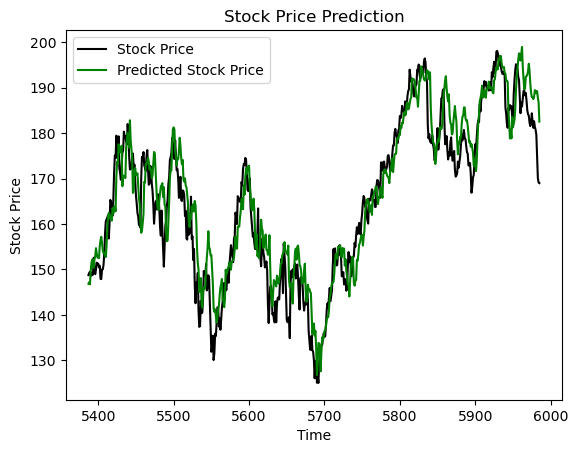

In [101]:
# Predict the stock price
predicted = model.predict(X_test)
predicted = np.array(predicted[:, 0]).reshape(-1, 1)

Y_test_to_plot = Y_test[:, 0]

# Convert predicted and test_label back to original scale
temp = stock["Close"][n_train:n_train+len(X_test)]
Y_test_to_plot = np.multiply(Y_test_to_plot.flatten(), temp) + np.array(temp)
predicted = np.multiply(predicted.flatten(), temp) + np.array(temp)
    

# Plot the results
plt.plot(Y_test_to_plot, color='black', label='Stock Price')
plt.plot(predicted, color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [102]:
# Build a simple trading strategy

initial_capital = 1000000  # Initial capital
current_capital = initial_capital  # Current capital
shares = 0  # Number of shares initially owned

# Iterate through each day's data
for i in range(len(Y_test_to_plot) - 1):
    real_price_today = Y_test_to_plot.iloc[i]  # Real price today
    predicted_price_tomorrow = predicted.iloc[i + 1]  # Predicted price tomorrow

    if predicted_price_tomorrow > real_price_today:
        # Buy as many shares as possible with available capital
        shares_to_buy = current_capital // real_price_today
        shares += shares_to_buy
        current_capital -= shares_to_buy * real_price_today

    elif predicted_price_tomorrow < real_price_today:
        # Sell all shares
        current_capital += shares * real_price_today
        shares = 0

# At the end of the simulation, calculate the final amount based on the last day's real price
final_amount = current_capital + shares * Y_test_to_plot.iloc[-1]
return_percentage = (final_amount - initial_capital) / initial_capital * 100
num_days = len(Y_test_to_plot) - 1

print("Final amount:", final_amount)
print("Return percentage:", return_percentage)
print("Number of days:", num_days)


Final amount: 1144094.8777769988
Return percentage: 14.409487777699878
Number of days: 598


In [103]:
df = pd.DataFrame({"Epochs": range(1, 41),
                   "Val_loss multi_pip": val_loss})

df

,Epochs,Val_loss multi_pip
0,1,0.002653
1,2,0.002146
2,3,0.001700
3,4,0.001939
4,5,0.002094
5,6,0.001674
6,7,0.001563
7,8,0.001565
8,9,0.001932
9,10,0.001627


In [104]:
df["Val_loss_base"] = [0.002756  , 0.0040571 , 0.00276219, 0.00311519, 0.00212184,
       0.00515425, 0.00199783, 0.00223672, 0.00191935, 0.00199193,
       0.00332931, 0.00420615, 0.00313031, 0.00350515, 0.00167751,
       0.00318693, 0.00278405, 0.00221533, 0.00231716, 0.00175181,
       0.00319397, 0.00150185, 0.00155807, 0.00220887, 0.00163749,
       0.00144784, 0.0016093 , 0.0039259 , 0.00269059, 0.00196186,
       0.00147689, 0.0016535 , 0.0016085 , 0.00198416, 0.00152609,
       0.00152403, 0.00230544, 0.00205146, 0.00180376, 0.00158389]

In [105]:
df

,Epochs,Val_loss multi_pip,Val_loss_base
0,1,0.002653,0.002756
1,2,0.002146,0.004057
2,3,0.001700,0.002762
3,4,0.001939,0.003115
4,5,0.002094,0.002122
5,6,0.001674,0.005154
6,7,0.001563,0.001998
7,8,0.001565,0.002237
8,9,0.001932,0.001919
9,10,0.001627,0.001992


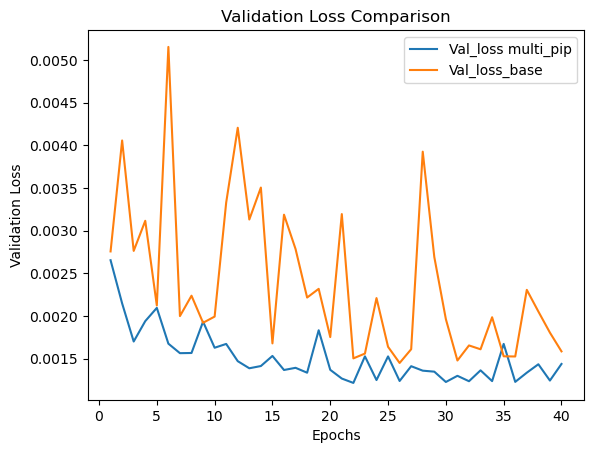

In [106]:
df.plot(x='Epochs', y=['Val_loss multi_pip', 'Val_loss_base'])
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()